## We check if there has been changes in classification results using the summarized text
- We'd expect with Tf-IDF vectorization, if there's a reduction in the amount of text, there should be a decrease in the model accuracy.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import re
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, font='Arial')

In [244]:
def plot_confusion_matrix(cf, scale_by='Recall', figname='../figure/cf.png'):
    if scale_by == 'Recall':
        recall_scale = np.sum(cf, axis=1)
        scaled = cf / recall_scale
    elif scale_by == 'Precision':
        precision_scale = np.sum(cf, axis=0)
        scaled = cf / precision_scale
    else:
        scaled = cf
        
    f, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(scaled, cmap='Blues', cbar=None, annot=True, fmt=".2f")
    ax.set_xticklabels(shortened, rotation=60)
    ax.set_yticklabels(shortened, rotation=0);
    f.savefig(figname, bbox_inches='tight', dpi=300)

### Process and tokenize both original text and the summary (and save to file)

In [184]:
file = '../output/with_summarized_10_sent.csv''
df = pd.read_csv(file, usecols=['Complaint ID', 'Product', 'Issue', 'Consumer complaint narrative'])
import re
def preprocess_tokenize(texts):
    special = re.compile(r'http\S+|www\S+|[^a-zA-Z ]+|xx+')
    docs_orig = [' '.join(special.sub('', doc.lower()).split()) for doc in texts]
    tokenized_orig = []
    for doc in nlp.pipe(docs_orig, disable=['tagger', 'parser', 'ner']):
        tokenized_orig.append(" ".join(token.lemma_.lower() for token in doc if not token.is_stop and not token.is_space \
                and not token.is_punct and not token.like_num))
    return tokenized_orig


tokenized_orig = preprocess_tokenize(df['Consumer complaint narrative'].values)
tokenized_summ = preprocess_tokenize(df['summarized'].values)

df['orig'] = tokenized_orig
df['summ'] = tokenized_summ
df.dropna().to_csv('../data/with_summarized_tokenized_10_sent.csv', index=False)

## Machine Learning Models
Build a simple logistic regression model with Tf-IDF vectorization

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

We don't predict the `other services` category because there are too few data.

In [227]:
valid_targets = ['Debt collection', 'Mortgage', 'Student loan',
       'Payday loan, title loan, or personal loan',
       'Credit card or prepaid card', 'Consumer Loan',
       'Money transfer, virtual currency, or money service',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Bank account or service']  
valid_df = df[df.Product.isin(valid_targets)]
targets = sorted(valid_df['Product'].unique())
shortened = sorted(['Credit Reporting', 'Debt Collection', 'Mortgage', 'Credit Card', 'Banking Service', 'Student Loan',
            'Consumer Loan', 'Money Transfer', 'Payday Loan'])

### Train-test split & vectorization

In [211]:
train_df, test_df = train_test_split(valid_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [212]:
X_train_orig, X_val_orig = train_df['orig'].values, val_df['orig'].values
X_train_summ, X_val_summ = train_df['summ'].values, val_df['summ'].values
y_train, y_val = train_df['Product'].values, val_df['Product'].values

### tf-idf using original text

In [155]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=1000)
tfidf_vect.fit(X_train_orig)
X_train_orig_tfidf = tfidf_vect.transform(X_train_orig)
X_val_orig_tfidf = tfidf_vect.transform(X_val_orig)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=1000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

### tf-idf using summarized text

In [205]:
tfidf_vect2 = TfidfVectorizer(analyzer='word', max_features=1000)
tfidf_vect2.fit(X_train_summ)
X_train_summ_tfidf = tfidf_vect2.transform(X_train_summ)
X_val_summ_tfidf = tfidf_vect2.transform(X_val_summ)

### Logistic Regression

#### Model built from original data

In [215]:
lr_orig = LogisticRegressionCV(max_iter=500, class_weight='balanced', multi_class='auto', solver='lbfgs', n_jobs=3)
lr_orig.fit(X_train_orig_tfidf, y_train)

pred_orig = lr_orig.predict(X_val_orig_tfidf)

/Users/sueliu/Mudano/customer-complaints/venv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [216]:
orig_report_df = pd.DataFrame(classification_report(y_val, pred_orig, output_dict=True)).T

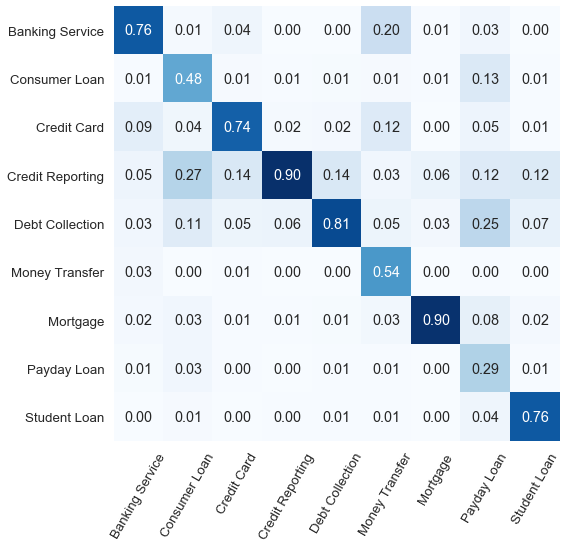

In [247]:
cf = confusion_matrix(y_val, pred_orig)
plot_confusion_matrix(cf, scale_by='Precision', figname='../figures/cf_precision_lr.png')

In [217]:
orig_report_df

,precision,recall,f1-score,support
Bank account or service,0.762208,0.782965,0.772447,4884.00000
Consumer Loan,0.478474,0.677992,0.561022,2590.00000
Credit card or prepaid card,0.738057,0.785111,0.760857,7576.00000
"Credit reporting, credit repair services, or other personal consumer reports",0.904077,0.756988,0.824020,23756.00000
Debt collection,0.813352,0.774088,0.793234,15267.00000
"Money transfer, virtual currency, or money service",0.543235,0.819647,0.653411,1303.00000
Mortgage,0.895072,0.903370,0.899202,9169.00000
"Payday loan, title loan, or personal loan",0.289259,0.682096,0.406242,1145.00000
Student loan,0.762346,0.886253,0.819644,3710.00000
accuracy,0.788890,0.788890,0.788890,0.78889


### Support Vector Machines

In [218]:
from sklearn.svm import LinearSVC
svc = LinearSVC(class_weight='balanced', random_state=42)
svc.fit(X_train_orig_tfidf, y_train)
svc_orig_pred = svc.predict(X_val_orig_tfidf)
svc_orig_report = pd.DataFrame(classification_report(y_val, svc_orig_pred, output_dict=True)).T

### Find mis-classified items

In [250]:
abbrev = ['BS', 'CL', 'CC', 'CR', 'DC', 'MT', 'MO', 'PL', 'SL']

In [252]:
results_val_df = val_df.copy()
pred = lr_orig.predict(X_val_orig_tfidf)
results_val_df['pred'] = pred
pred_proba = lr_orig.predict_proba(X_val_orig_tfidf)
proba_df = pd.DataFrame(pred_proba, columns=['pred_'+t for t in abbrev])
proba_df['max_prob'] = proba_df.max(axis=1)
proba_df['Complaint ID'] = results_val_df['Complaint ID'].values
predicted_df = pd.merge(results_val_df, proba_df, on='Complaint ID')

In [257]:
threshold = predicted_df[predicted_df.max_prob > 0.8]
wrong_df = threshold[threshold['Product'] != threshold['pred']]

In [265]:
hist_cols = ['pred_' + a for a in abbrev]

Actual:  Consumer Loan
Predicted:  Payday loan, title loan, or personal loan
Probability:  0.8507117997181024
Narrative:  I was approved for a loan in the amount of {$16000.00} in XXXX XXXX and my first payment of {$370.00} was deducted from my XXXX account in XXXX XXXX. Loan # XXXX I was automatically set up on automatic withdrawal payments and was told that I would be able to remove the automatic withdrawal payment option in the future if I wanted. 

What was not disclosed to me was that if I removed the automatic withdrawal from my account, I would be assessed a {$7.00} fee for each payment I sent the company. After closing the XXXX account, I send payments thru XXXX XXXX Bill payment system to the Lending Club. 

XXXX/XXXX/XXXX send XXXX ( which includes the XXXX fee ) delivered by The Lending Club by XXXX/XXXX/XXXX XXXX/XXXX/XXXX send XXXX ( which includes the XXXX fee ) delivered by The Lending Club by XXXX/XXXX/XXXX XXXX/XXXX/XXXX send XXXX ( which includes the XXXX fee ) delive

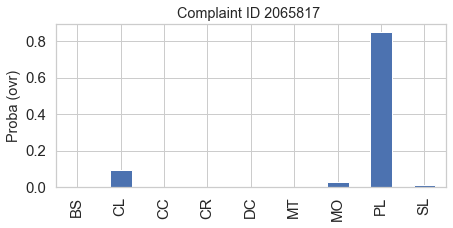

In [301]:
idx = 3
wrong_example = wrong_df.iloc[idx]
complaint_id = wrong_example['Complaint ID']
f, ax = plt.subplots(figsize=(7, 3))
sns.set_style('whitegrid')
pd.DataFrame(wrong_example[hist_cols]).plot(kind='bar', ax=ax, legend=False, fontsize=15, title='Complaint ID {} '.format(complaint_id))
ax.set_ylabel('Proba (ovr)')
ax.set_xticklabels(abbrev);
f.savefig('../figures/wrong_examples_complaint_{}.png'.format(complaint_id), bbox_inches='tight', dpi=300)
print('Actual: ', wrong_example['Product'])
print('Predicted: ', wrong_example['pred'])
print('Probability: ', wrong_example['max_prob'])
print('Narrative: ', wrong_example['Consumer complaint narrative'])

### Models built from summaries only

In [302]:
lr_summ = LogisticRegression(C=1.0, max_iter=500, class_weight='balanced', multi_class='auto', 
                             solver='lbfgs', n_jobs=3)
lr_summ.fit(X_train_summ_tfidf, y_train)
pred_summ = lr_summ.predict(X_val_summ_tfidf)

In [303]:
report_summ = pd.DataFrame.from_dict(classification_report(y_val, pred_summ, output_dict=True)).T

In [305]:
svc_summ = LinearSVC(class_weight='balanced', random_state=42)
svc_summ.fit(X_train_summ_tfidf, y_train)
svc_pred_sum = svc_summ.predict(X_val_summ_tfidf)

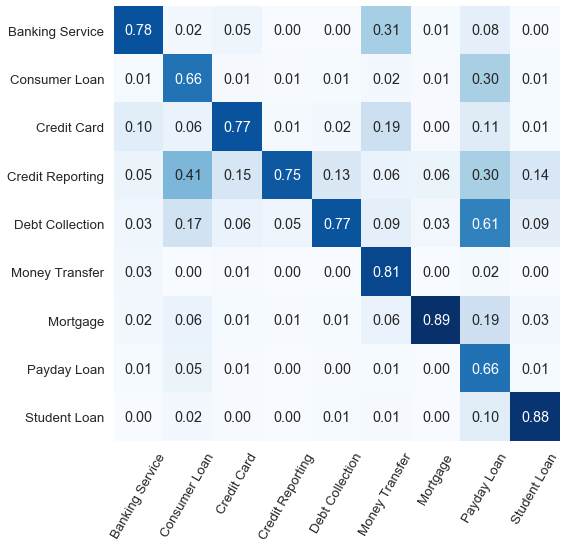

In [310]:
plot_confusion_matrix(confusion_matrix(y_val, pred_summ), scale_by='Recall', figname='../figures/lr_summ_5_sent_recall.png')

In [307]:
report_svc_summ = pd.DataFrame.from_dict(classification_report(y_val, svc_pred_sum, output_dict=True)).T
report_svc_summ

,precision,recall,f1-score,support
Bank account or service,0.737401,0.796888,0.765991,4884.000000
Consumer Loan,0.534121,0.628571,0.577510,2590.000000
Credit card or prepaid card,0.741301,0.776135,0.758318,7576.000000
"Credit reporting, credit repair services, or other personal consumer reports",0.891442,0.790537,0.837963,23756.000000
Debt collection,0.812823,0.793869,0.803234,15267.000000
"Money transfer, virtual currency, or money service",0.560852,0.767460,0.648088,1303.000000
Mortgage,0.882856,0.900862,0.891768,9169.000000
"Payday loan, title loan, or personal loan",0.360931,0.582533,0.445707,1145.000000
Student loan,0.773761,0.871159,0.819577,3710.000000
accuracy,0.799121,0.799121,0.799121,0.799121


### Summary:
So there is a slight decrease in model performance, but not significant enough to warrant serious attention: accuracy drops from 79% to 78%, even though we are only taking the top 5 relevant sentences.

Save models

In [309]:
import pickle

models = {'lr_orig': lr, 'lr_summ': lr_summ, 'tfidf_orig': tfidf_vect, 'tfidf_summ': tfidf_vect2}
with open('../models/linear_regression/lr_5_sent.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)
    
models = {'svc_orig': svc, 'svc_summ': svc_summ, 'tfidf_orig': tfidf_vect, 'tfidf_summ': tfidf_vect2}
with open('../models/svc/svc_5_sent.pickle', 'wb') as f:
    pickle.dump(models, f, pickle.HIGHEST_PROTOCOL)